In [1]:
import torch
import torch.nn as nn

# Import the gym module
import gym
import numpy as np
import time 

from matplotlib import pyplot as plt

import random

In [2]:
# Create a breakout environment
env = gym.make('PongNoFrameskip-v4')

In [3]:
def preprocess(img):
    # 저장할 때는 전처리를 거친 후 np.array 형태로 저장
    img = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])
    #img = np.mean(img, axis=2, dtype=np.uint8)
    img = img[::2, ::2][17:97] # downsample(1/2) & to square
    img = np.expand_dims(img, 0) # (1, 80, 80)
    return img.astype(np.uint8)

In [4]:
s = env.reset()
done = False
n = 0
while not done:
    a = env.action_space.sample()
    s, _, done, _ = env.step(a)
    n += 1
n

3373

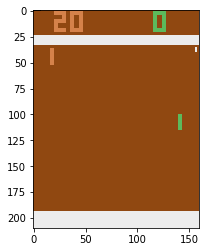

In [5]:
plt.imshow(s)

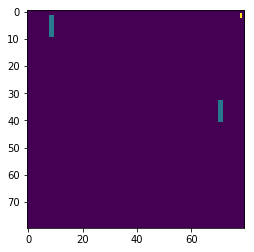

In [6]:
plt.imshow(preprocess(s)[0])

In [7]:
from collections import deque
import random 

class ReplayMemory(object):
    def __init__(self, capacity):
        self.deque = deque(maxlen=capacity)
    
    def append(self, state, action, reward, next_state, done):
        self.deque.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        return random.sample(self.deque, batch_size)
    
    def __len__(self):
        return len(self.deque)

In [8]:
class FrameHistory(object):
    # consecutive frame을 4개씩 병합하여 새로운 x를 하나씩 만드는 클래스
    # 만들어진 x는 4개씩 concat하고 s를 만들어서 DQN의 input으로 들어감
    def __init__(self, env, k_history=4):
        self.state_deque = deque(maxlen=k_history) # [x1, x2, x3, x4]
        self.frame_history_deque = deque(maxlen=k_history) #[s1, s2, s3, s4]
        self.k_history = k_history
        
        # 최초에는 초기 화면(env.reset)으로 채워둠
        self.env = env
        self.initial_state = self.preprocess(self.env.reset())
        self.reset()
        
    def preprocess(self, img):
        # 저장할 때는 전처리를 거친 후 np.array 형태로 저장
        img = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])
        img = img[::2, ::2][17:97] # downsample(1/2) & to square
        img = np.expand_dims(img, 0) # (1, 80, 80)
        return img.astype(np.uint8)
    
    def append_frame(self, s):
        # if full, aggregate and clear old frames, append new frame to history queue
        if len(self) == self.k_history:
            self.state_deque.append(self.aggregate_frame())
            
        self.frame_history_deque.append(self.preprocess(s))
        return
        
    def aggregate_frame(self):
        if len(self) < self.k_history:
            raise ValueError('not enough frames in history, expected %s, but got %s'%(self.k_history, len(self)))
        
        # element-wise maximum to aggregate
        return np.maximum.reduce([self.frame_history_deque.pop() for _ in range(len(self))][-k_history//2:])
    
    def get_state(self):
        S = np.array([self.state_deque[i] for i in range(self.k_history)]) # S = [x1, x2, x3, x4], (4, 1, 80, 80)
        S = np.swapaxes(S, 0, 1) # (1, 4, 80, 80)
        return S
    
    def reset(self):
        self.frame_history_deque = deque(maxlen=k_history)
        self.state_deque = deque(maxlen=k_history)
        
        for _ in range(self.k_history):
            self.state_deque.append(self.initial_state)
    
    def __len__(self):
        return len(self.frame_history_deque)

In [9]:
class DDQN(nn.Module):
    # Dueling DQN
    def __init__(self, in_dim, n_action):
        super(DDQN, self).__init__()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_dim, 32, (8, 8), stride=4), nn.ReLU(), # conv 1
            nn.Conv2d(32, 64, (4, 4), stride=2), nn.ReLU(), # conv 2
            nn.Conv2d(64, 64, (3, 3), stride=1), nn.ReLU() # conv 3
        )
        # V(s) : value-stream
        self.value_stream = nn.Sequential(
            nn.Linear(64*6*6, 512), nn.ReLU(), # hidden layer
            nn.Linear(512, 1)
        )
        
        # A(s,a) : action-stream
        self.action_stream = nn.Sequential(
            nn.Linear(64*6*6, 512), nn.ReLU(),
            nn.Linear(512, n_action)
        )
        
    def to_tensor(self, img):
        img = torch.tensor(img, dtype=torch.float32, device=self.device).cuda(non_blocking=True) # to tensor
        img /= 255                                   # normalize into 0-1
        while img.dim() < 4 :                        # 4-dim
            img = img.unsqueeze(0)
        return img
        
    def forward(self, frames):
        frames = self.to_tensor(frames) 
        conved = self.conv(frames)
        conved = conved.view(conved.size(0), -1)
        
        # key of Dueling DQN : Q(s,a_i) = V(S) + A(s,a_i) - mean(A)
        value = self.value_stream(conved) # V(s), dim=(batch_size, 1)
        action = self.action_stream(conved) # A(s,a), dim=(batch_size, n_action)
        
        output = value + (action - torch.mean(action, dim=1, keepdim=True)) # V(s) + (A(s,a_i) - mean(A)), dim=(batch_size, n_action)
        return output

In [10]:
#############
k_history = 4 ## number of skipped frame
#############

behavior_net = DDQN(in_dim=k_history, n_action=env.action_space.n)
target_net = DDQN(in_dim=k_history, n_action=env.action_space.n)

behavior_net.to(behavior_net.device) # model to cuda
target_net.to(target_net.device)     # model to cuda

DDQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (value_stream): Sequential(
    (0): Linear(in_features=2304, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
  (action_stream): Sequential(
    (0): Linear(in_features=2304, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [11]:
def epsilon_decay(n_total_frame):
    return np.max([1 - 9.0*1e-07*n_total_frame, 0.1])    

In [12]:
def grow_batch_size(current_memory, max_memory):
    # grow batch size from 32 to 128 as respect to memory size
    memory_ratio = current_memory / max_memory
    new_batch_size = int(32 + 32*memory_ratio)
    return new_batch_size

In [13]:
class Fitter():
    def __init__(self, env, behavior_net, target_net, k_history=4, train_method='DQN'):
        self.env = env
        self.train_method = train_method
        
        # networks
        self.behavior_net = behavior_net
        self.target_net = target_net
        self.behavior_net.to(self.behavior_net.device) # model to cuda
        self.target_net.to(self.target_net.device)     # model to cuda
        
        # train parameters
        self.gamma = 0.99 #as written in paper
        self.criterion = nn.SmoothL1Loss() # huber loss (error-clipping)
        self.optim = torch.optim.RMSprop(self.behavior_net.parameters(), lr=0.00025, alpha=0.95, eps=0.01) #as written in paper in Rainbow
        self.k_history = k_history
        
        # train details
        self.total_frame = 0
        self.total_episode = 0
        self.batch_size = 32
        self.max_replay = 1000000 # as written in paper
        self.min_replay = 50000 # as written in the paper
        self.replay_memory = ReplayMemory(self.max_replay)
        self.frame_history = FrameHistory(env=self.env, k_history=self.k_history)
        
        self.train_reward_ls = []
        self.test_reward_ls = []
    
    
    def train(self, max_total_frame):
        while self.total_frame < max_total_frame :
            # game(episode) begins
            self.env.reset()  
            self.frame_history.reset() #frame history reset
            e = epsilon_decay(self.total_frame)
            
            episode_frame = 0         # each episode의 step의 횟수 
            episode_r_total = 0   # each episode의 reward sum
            
            done = False
            while not done:
                episode_frame += 1
                
                # start of every k consecutive frames, choose action!                
                if episode_frame%self.k_history == 1:
                    # S = [x1, x2, x3, x4] for neural-network input
                    # x represents feature(element-wise max) from every k consecutive frames(k*s)
                    S = self.frame_history.get_state()
                    immediate_r = 0   # sum of reward for the following k frames
                    
                    # Choose an action by e-greedy
                    if np.random.rand(1) < e :
                        a = self.env.action_space.sample()
                    else:
                        q_pred = self.behavior_net(S)
                        a = torch.argmax(q_pred).item()
                
                # repeat the same action k times
                s_next, r, done, info, = self.env.step(a)
                self.frame_history.append_frame(s_next)
                
                immediate_r += self.clip_reward(r)
                episode_r_total += r
                
                # end of every k consecutive frames
                # genenrate new x, and update S
                if episode_frame%self.k_history == 0 :
                    S_new = self.frame_history.get_state()
                    self.replay_memory.append(S, a, immediate_r, S_new, done)
                    
                # no training when not enough replay
                if len(self.replay_memory) < self.min_replay:
                    continue
                
                # train every k steps
                if episode_frame % self.k_history == 0:
                    mini_batch = self.replay_memory.sample(self.batch_size)
                    self.train_batch(mini_batch)   
                
                self.total_frame += 1
                # update target_net every 10,000 steps
                if self.total_frame%10000== 0 :
                    self.update_target()
                
            
            # single-episode(game) is now done
            # if not enough memory, save more
            if len(self.replay_memory) < self.min_replay:
                print('Not enough replay yet, expected more than %s, but %s instead'%(self.min_replay, len(self.replay_memory)))
            
            # if enough memory, check train reward
            else:
                print('Train Episode :%s, Train reward : %s, Total Frame : %s'%(self.total_episode, episode_r_total, self.total_frame))
                self.total_episode += 1
                self.train_reward_ls.append(episode_r_total)
            
                # testing when enough replay, every 10 episodes
                if self.total_episode%10 == 0:
                    self.test()           
    
    
    def clip_reward(self, r):
        return np.sign(r)
    
    
    def train_batch(self, mini_batch):
        batch_size = len(mini_batch)
        S = np.array([tup[0] for tup in mini_batch]).squeeze(1) # State
        A = np.array([tup[1] for tup in mini_batch]) # actions
        R = np.array([tup[2] for tup in mini_batch]) # rewards
        S_next = np.array([tup[3] for tup in mini_batch]).squeeze(1) # next_State
        D = np.array([tup[4] for tup in mini_batch]) # dones
        
        q_targets = self.target_net(S) # Q-values of current state with targetDDQN
        q_targets_next = self.target_net(S_next) # Q-values of next state from targetDDQN
        
        if self.train_method=='DQN':
            for i in range(batch_size):
                a, r, done = A[i], R[i], D[i]
                if done:
                    q_targets[i, a] = r
                else:
                    q_targets[i, a] = r + self.gamma*torch.max(q_targets_next[i])
        
        elif self.train_method=='DoubleDQN':
            next_behavior_net_actions = torch.argmax(self.behavior_net(S_next), dim=1) # choose argmax actions from behaviorDDQN in S_next
                    
            for i in range(batch_size):
                a, r, done = A[i], R[i], D[i]
                next_behavior_net_action = next_behavior_net_actions[i].item() # choose argmax actions from behaviorDDQN in S_next
                if done:
                    q_targets[i, a] = r
                else:
                    q_targets[i, a] = r + self.gamma*q_targets_next[i, next_behavior_net_action]
            
        # 예측치(pred)와 목표치(true)
        q_behaviors = self.behavior_net(S)
        self.optim.zero_grad()
        loss = self.criterion(q_targets, q_behaviors)
        loss.backward()
        self.optim.step()
        return

    
    def update_target(self):
        self.target_net.load_state_dict(self.behavior_net.state_dict())
        return 
    
    
    def test(self):
        self.env.reset()
        self.frame_history.reset()
        e = 0.05 # e-greedy, 
        
        episode_frame = 0
        episode_r_total = 0
        
        done=False
        while not done:
            episode_frame += 1
            
            # at the beginning of every 4-th frame
            # choose an action
            if episode_frame%self.k_history==1:
                # e-greedy search, e=0.05 
                if np.random.rand(1) < e:
                    a = self.env.action_space.sample()
                else:
                    S = self.frame_history.get_state()
                    a = torch.argmax(self.behavior_net(S)).item()
            
            s, r, done, _ = self.env.step(a)
            self.frame_history.append_frame(s)
            episode_r_total += r
        
        self.test_reward_ls.append(episode_r_total)
        print('Total Step: %s \t Total Score: %s'%(episode_frame, episode_r_total))
        return episode_r_total

In [14]:
fitter = Fitter(env, behavior_net, target_net, k_history=k_history, train_method='DoubleDQN')

In [15]:
max_frame = 10000000
fitter.train(max_frame)

Not enough replay yet, expected more than 50000, but 764 instead
Not enough replay yet, expected more than 50000, but 1694 instead
Not enough replay yet, expected more than 50000, but 2546 instead
Not enough replay yet, expected more than 50000, but 3490 instead
Not enough replay yet, expected more than 50000, but 4468 instead
Not enough replay yet, expected more than 50000, but 5665 instead
Not enough replay yet, expected more than 50000, but 6457 instead
Not enough replay yet, expected more than 50000, but 7250 instead
Not enough replay yet, expected more than 50000, but 8074 instead
Not enough replay yet, expected more than 50000, but 8941 instead
Not enough replay yet, expected more than 50000, but 9751 instead
Not enough replay yet, expected more than 50000, but 10588 instead
Not enough replay yet, expected more than 50000, but 11430 instead
Not enough replay yet, expected more than 50000, but 12327 instead
Not enough replay yet, expected more than 50000, but 13207 instead
Not eno

Train Episode :69, Train reward : -20.0, Total Frame : 251711
Total Step: 3408 	 Total Score: -21.0
Train Episode :70, Train reward : -20.0, Total Frame : 255386
Train Episode :71, Train reward : -20.0, Total Frame : 259587
Train Episode :72, Train reward : -20.0, Total Frame : 263407
Train Episode :73, Train reward : -21.0, Total Frame : 267199
Train Episode :74, Train reward : -20.0, Total Frame : 271109
Train Episode :75, Train reward : -21.0, Total Frame : 274165
Train Episode :76, Train reward : -21.0, Total Frame : 277461
Train Episode :77, Train reward : -21.0, Total Frame : 280517
Train Episode :78, Train reward : -21.0, Total Frame : 283685
Train Episode :79, Train reward : -19.0, Total Frame : 287940
Total Step: 3056 	 Total Score: -21.0
Train Episode :80, Train reward : -20.0, Total Frame : 291402
Train Episode :81, Train reward : -21.0, Total Frame : 294458
Train Episode :82, Train reward : -21.0, Total Frame : 297514
Train Episode :83, Train reward : -21.0, Total Frame : 3

Train Episode :192, Train reward : -21.0, Total Frame : 669278
Train Episode :193, Train reward : -21.0, Total Frame : 672334
Train Episode :194, Train reward : -21.0, Total Frame : 675630
Train Episode :195, Train reward : -21.0, Total Frame : 678686
Train Episode :196, Train reward : -21.0, Total Frame : 682057
Train Episode :197, Train reward : -20.0, Total Frame : 685591
Train Episode :198, Train reward : -20.0, Total Frame : 689424
Train Episode :199, Train reward : -19.0, Total Frame : 693172
Total Step: 3367 	 Total Score: -20.0
Train Episode :200, Train reward : -19.0, Total Frame : 696918
Train Episode :201, Train reward : -21.0, Total Frame : 700281
Train Episode :202, Train reward : -21.0, Total Frame : 703337
Train Episode :203, Train reward : -21.0, Total Frame : 706393
Train Episode :204, Train reward : -21.0, Total Frame : 709449
Train Episode :205, Train reward : -20.0, Total Frame : 712816
Train Episode :206, Train reward : -21.0, Total Frame : 715872
Train Episode :20

KeyboardInterrupt: 

In [17]:
len(fitter.frame_history)

4

In [31]:
torch.argmax(fitter.behavior_net(fitter.frame_history.get_state()), dim=1).item()

1

In [33]:
q_values = fitter.behavior_net(fitter.frame_history.get_state())

In [56]:
S, a, r, S_next, done = fitter.replay_memory.sample(1)[0]

In [38]:
q_values = fitter.behavior_net(S)

In [88]:
S_new = np.concatenate([S_next, S])

In [89]:
next_q_values = fitter.target_net(S_new)

In [90]:
next_q_values

tensor([[-0.2933, -0.2924, -0.2957, -0.2936, -0.2954, -0.2942],
        [-0.2935, -0.2925, -0.2961, -0.2940, -0.2957, -0.2946]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [93]:
torch.max(next_q_values, dim=1)

(tensor([-0.2924, -0.2925], device='cuda:0', grad_fn=<MaxBackward0>),
 tensor([1, 1], device='cuda:0'))

In [91]:
next_q_values.max(dim=1)[0]

tensor([-0.2924, -0.2925], device='cuda:0', grad_fn=<MaxBackward0>)

In [65]:
next_q_values.gather(1, torch.max(next_q_values, dim=1)[1].unsqueeze(1)).squeeze(1)

tensor([-0.2904], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [ ]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    q_values      = current_model(state)
    next_q_values = target_model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - expected_q_value.detach()).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss